In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import PyBoolNet
import networkx as nx
def read_rules_text(model_name):
    '''
    Reads in the Boolean model
    '''
    rules_file=model_name
    with open(rules_file,'r') as f:
        rules=f.read()
    rules=rules.replace('#BOOLEAN RULES','')
    return rules

            
def get_stable_motif_successions_recursive(rules,node_substitutions, succession):
    
    '''
    Recursively builds lines of successively stabilising trap spaces based on the 
    get_maximal_trap_spaces_after_percolation() function 
    '''   
    
    new_rules,maxts=get_maximal_trap_spaces_after_percolation(rules,node_substitutions)
    if len(maxts)==0:
        yield succession
    else:
        for SM in maxts:
            yield from  get_stable_motif_successions_recursive(new_rules,SM,succession+[SM])


def get_maximal_trap_spaces_after_percolation(rules,node_substitutions):  
    
    '''
    Given a set of Boolean rules, substitutes the values given in node substitutions and after finding the
    prime implicants it further simplifies the model by finding the LDOI of the substitution using
    PyBoolNet.PrimeImplicants.percolate_and_remove_constants(primes) and further reducing the rules. 
    Finally it finds the stable motifs (maximal trap spaces) using 
    PyBoolNet.AspSolver.trap_spaces(primes, "max")
    
    '''
    rules_new=rules[:]
    if len(node_substitutions)==0:
        rules_new=rules[:]
    else:
        for node,value in node_substitutions.items():
            rules_new='\n'.join([s for s in rules_new.split('\n') if s.split(',')[0]!=node])
            rules_new=rules_new.replace(node,str(value))
    primes = PyBoolNet.FileExchange.bnet2primes(rules_new)
    if len(rules_new.strip())==0:
        return '',[]
    
    constants=PyBoolNet.PrimeImplicants.percolate_and_remove_constants(primes)
    for line in rules_new.strip().split('\n'):
        node=line.split(',')[0].strip()
        rule=line.split(',')[1].strip()
        if node in constants.keys():
            rules_new=rules_new.replace(line+'\n','')
        for n,v in constants.items():
            rule_new=rule.replace(n,str(v))
            rules_new=rules_new.replace(rule,rule_new)
    primes = PyBoolNet.FileExchange.bnet2primes(rules_new)
    maxts = PyBoolNet.AspSolver.trap_spaces(primes, "max")

    return rules_new,maxts
    
def get_final_state_corresponding_to_trap_space_succession(rules,succession):
    
    '''
    Based on a succession line it finds the final steady state and/or oscillating components.
    We use this function in order to not burden the recursion with storing what has been substituted already
    and we infer the final steady state once the succession lines were built. 
    
    If a node oscillates by the end it will assign the string "osc" to the corresponding variable in
    the returned dictionary
    '''

    node_substitutions={}
    for mts in succession:
        for n,v in mts.items():
            node_substitutions[n]=str(v)
    new_lines=[]
    for line in rules.strip().split('\n'):
        n,rule=line.split(',')
        for node,value in node_substitutions.items():
            rule=rule.replace(node,str(value))
        new_lines.append(n+',\t'+rule)
    rules_new='\n'.join(new_lines)            
    primes = PyBoolNet.FileExchange.bnet2primes(rules_new)
    steady = PyBoolNet.AspSolver.steady_states(primes)
    constants=PyBoolNet.PrimeImplicants.percolate_and_remove_constants(primes)
    if len(steady)==1:
        return steady[0]
    elif len(steady)==0: #we are dealing with an oscillation
        nodes= [s.split(',')[0].strip() for s in rules.split('\n') if s.strip()!='']
        final_state={} 
        for n,v in node_substitutions.items():
            final_state[n]=str(v)
            if n in nodes:
                nodes.remove(n)
        for n,v in constants.items():
            final_state[n]=str(v)
            if n in nodes:
                nodes.remove(n)
        for n in nodes:
            final_state[n]='osc'
        return final_state
    else:
        raise ValueError('The succession does not lead to a unique attractor.')

def edge_list_from_succession_line(succession):
    
    '''Transfroms the succession line into an edge list'''
    
    x=[]
    for k in succession:
        s=''
        for node,state in sorted(k.items()):
            s+='%s=%s;'%(node,str(state))
        x.append(s)
    return zip(x[:-1],x[1:])
        


We read in the Boolean model and transform it into a PyBoolNet compatible syntax

In [15]:
model_='test.txt'

rules=read_rules_text(model_)

nodes= [s.split('*=')[0].strip() for s in rules.split('\n') if s.strip()!='']

print(nodes)

rules= rules.replace(' *=',',\t').replace('*=',',\t').replace('not ','!').replace(' and ',' & ').replace(' or ',' | ')

print(rules)


['A', 'B', 'C', 'D', 'E', 'Fx']

A,	B
B,	A
C,	A | !D
D,	C
E,	B & Fx
Fx,	E



We call the recusive algoritm to build the succession lines

In [16]:
starting_substitution={}
successions=list(get_stable_motif_successions_recursive(rules,starting_substitution,[]))

[{'A': 0, 'B': 0}, {'A': 1, 'B': 1}, {'E': 0, 'Fx': 0}]

A,	B
B,	A
C,	A | !D
D,	C
E,	B & Fx
Fx,	E

[]

C,	0 | !D
D,	C

[{'E': 1, 'Fx': 1}, {'E': 0, 'Fx': 0}]

E,	1 & Fx
Fx,	E

[{'A': 0, 'B': 0}, {'A': 1, 'B': 1}]

A,	B
B,	A
C,	A | !D
D,	C

[]

C,	0 | !D
D,	C

[]




Building a graph out of the successions

In [18]:

G_succession=nx.DiGraph()
for succession in successions:
    #fss is the final steady state (or oscillation that will be a leaf in our graph)
    fss=get_final_state_corresponding_to_trap_space_succession(rules,succession)
    print (succession+[fss])
    el=list(edge_list_from_succession_line(succession+[fss]))
    G_succession.add_edges_from(el)
    


[{'A': 0, 'B': 0}, {'A': '0', 'B': '0', 'E': '0', 'Fx': '0', 'C': 'osc', 'D': 'osc'}]
[{'A': 1, 'B': 1}, {'E': 1, 'Fx': 1}, {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'Fx': 1}]
[{'A': 1, 'B': 1}, {'E': 0, 'Fx': 0}, {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 0, 'Fx': 0}]
[{'E': 0, 'Fx': 0}, {'A': 0, 'B': 0}, {'E': '0', 'Fx': '0', 'A': '0', 'B': '0', 'C': 'osc', 'D': 'osc'}]
[{'E': 0, 'Fx': 0}, {'A': 1, 'B': 1}, {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 0, 'Fx': 0}]


We plot the graph

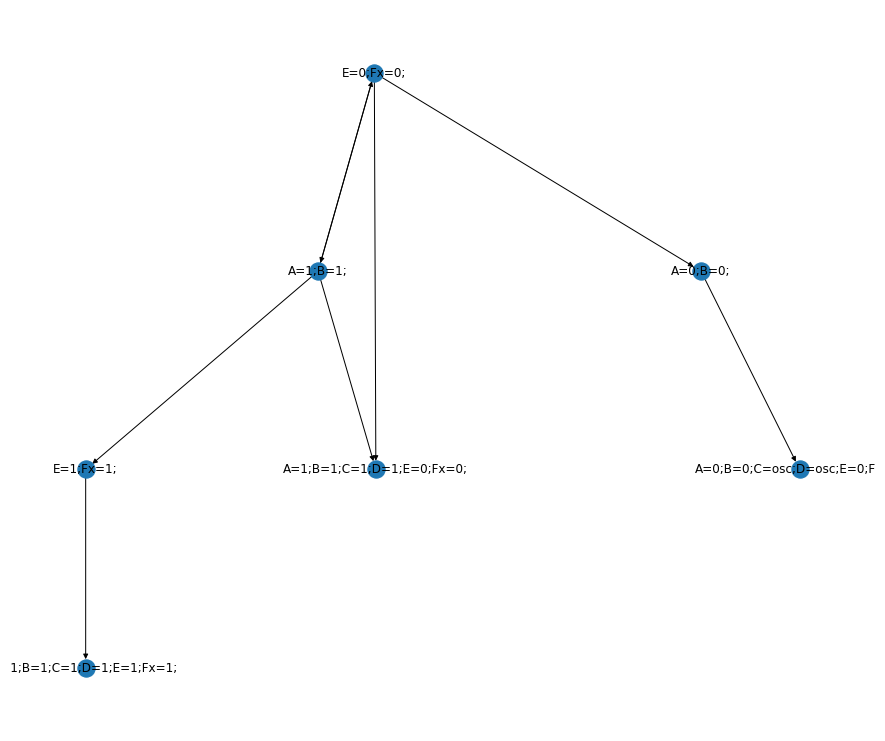

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
from networkx.drawing.nx_agraph import graphviz_layout
pos =graphviz_layout(G_succession, prog='dot')
nx.draw(G_succession, pos, with_labels=True, arrows=True)

In [20]:
for n in G_succession.nodes():
    print(n)
    G_succession.node[n]['label']=n

A=0;B=0;
A=0;B=0;C=osc;D=osc;E=0;Fx=0;
A=1;B=1;
E=1;Fx=1;
A=1;B=1;C=1;D=1;E=1;Fx=1;
E=0;Fx=0;
A=1;B=1;C=1;D=1;E=0;Fx=0;


In [21]:
nx.write_graphml(G_succession,'succession_graph_%s.graphml'%model_.replace('.txt',''))